# Fitting the DGF prior to samples from the LF model

## Notation

$u \sim q(u)$ is a sample from the LF model, $p(u)$ is the evidence $Z_u$ of fitting the LF sample $u$ with one of our DGF prior models.

## The KL expression

We use a Monte Carlo approximation to calculate the KL divergence:
$$ KL(q \leftarrow p) \approx \sum_r \log q(u_r) - \log p(u_r) \geq 0 $$ where $u_r \sim q(u)$. So we require that $q(u_r) > p(u_r)$. This makes sense because a particular waveform $u$ is of course much more probable under the LF model than our nonparametric GP model.

## Getting priors for the source parameters $\theta$ from this experiment

**NEW UPDATE**: just resample the individual posteriors and pool all samples, this is theoretically valid, and fit a nonlinear coloring bijector to the pool of samples. The model is $\theta$ (DGF prior samples), $u$ (DGF waveform), $\phi$ (LF parameters).

$$ p(\theta, u, \phi) = p(\theta|u) p(u|\phi) p(\phi) $$

The goal is $p(\theta)$. So

$$ p(\theta) = \int d\phi p(\phi) \big[ \int p(\theta|u) p(u|\phi) du \big] \simeq \int d\phi p(\phi) \big[ p(\theta|u(\phi)) \big] \approx {1\over N_\phi} \sum_{\phi_i \sim p(\phi)} p(\theta|u(\phi_i)) $$

Now we resample $p(\theta|u(\phi))$ to a 100 samples, i.e., we approximate by a sum of equally-weighted delta functions:

$$ p(\theta|u(\phi_i)) \approx {1\over 100} \sum_{j=1}^{100} \delta(\theta - \theta_{ij})$$

Doing this, we have now reduced $p(\theta)$ to a big sum of $100 N_\phi$ **equally-weighted** delta functions...

$$ p(\theta) \approx {1\over 100 N_\phi} \sum_{\phi_i \sim p(\phi)} \sum_{j=1}^{100} \delta(\theta - \theta_{ij}) $$

... and we can just fit our bijector to it. So we deal with capturing probability mass by (1) Monte Carlo sampling (from $\phi_i \sim p(\phi)$) and (2) resampling the posterior $p(\theta|u(\phi_i))$ to equally weighted samples.

**UPDATE on the paragraphs below in this section:** The number of dimensions (`len(u)`) is $O(100)$, so importance sampling doesn't work, because the weights have huge outliers which dominate the expectation values. This is entirely expected. We would need a huge number of samples to get a practically usable distribution of weights where the samples of the typical set are large enough in number to compensate the relatively few samples around the likelihood mode, which dominate the weights. This intuition is formalized in a simple relation between the variance of the importance sampling estimate and the KL divergence that we have here in [Au2003, Eq. 11].

To determine $p(\theta)$ from the sampled $u \sim q(u)$, we can use importance sampling such that $p(\theta) \approx \frac{\sum_r w_r p(\theta|u_r)}{\sum_r w_r}$ where $w_r = p(u_r)/q(u_r)$ and $u_r \sim q(u)$ (MacKay 2005, p. 361). In other words, reweigh the posterior samples by the importance sampling weights $w_r$.

By relying on this approximation we implicitly assert that our prior $p(\theta)$ gives rise to DGF waveforms $p(u|\theta)$ which are already close to the "true" ones $q(u)$. And indeed, we have built in smooth opening constraint, the null integral constraint, and the OQ parameter.

We can also get some feeling, of course, for how close $p(u|\theta)$ will typically be to $q(x)$ by the $KL(q \leftarrow p)$. I say "typically" because $p(u) = \int d\theta p(u|\theta) p(\theta)$, so we indeed both rely on our DGF Hilbert model $p(u|\theta)$ *and* sensible bounds and parametrization of the prior $p(\theta)$.

Another indicator of the quality of this approximation is whether the weights $w_r$ are reasonably similar in magnitude and no extreme outliers exist. And unfortunately these do exist: While most samples $u$ have $\log q(u) \sim O(1000)$, several of them also have a $\log q(u)$ of 1 or 2 orders magnitude larger; these are extreme outliers due to boundary effects of `Qa ~= 1`.

**Something else:** once we have fitted our prior in the $z$-domain (after nonlinear whitening), we can make it conditional on $T$, which is handy when we have Praat estimates $\hat T$ for $T$ available.

## Noise floor

**UPDATE**: we just use our $\text{Log}_{10}\text{Normal}$ priors for everything.

We add to the sample $u$ some noise to regularize the problem and install a hard lower bound $\delta^2$ for the DGF prior. This is also handy to regularize the probability $q(u)$, which we compute using a MAP approximation, thereby avoiding another nested sampling run.

The noise power term $\sigma_n^2$ of the GP is essentially a smoothing parameter because the GP won't like it to perfectly model the very sharp features of the LF waveform. It is lower bounded by the noise floor: $\sigma_n^2 \geq \delta^2$.

The "SNR" $\sigma_n^2/\delta^2$ is a good measure of the extent to which the GP went along in modeling the sharp features of the DGF waveform. In practice we can use the amount of dB above the noise floor. If the noise floor is at -60 dB, then typically $10\log_{10}(\sigma_n^2) \sim -40~dB$ so only 20 dB above the noise floor.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels
from dgf import constants
from dgf.prior import lf
from dgf.prior import source
from lib import lfmodel
from lib import klatt

import scipy.stats

fs = 10
rng = np.random.default_rng(41587)

2022-10-21 14:38:29.903872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-21 14:38:29.903925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-21 14:38:29.903929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Plot the samples from the LF model

The open quotient `Oq` of the LF model correlates only moderately with the OQ as we see it. Namely we see the OQ as a "hard" close where the DGF waveform is zero. The LF model has an exponential return phase and a "soft" close such that the `Oq` is quite fuzzily defined. So we cannot expect our inferred `Oq` to correspond with the `Oq` of LF, because of this soft return phase. Our implementation of `Oq` is just dividing the pitch period into a hard zero (closed) phase and a nonzero (open) phase.

In [2]:
lf_samples = source.get_lf_samples()

[Memory]6.1s, 0.1min    : Loading get_lf_samples...


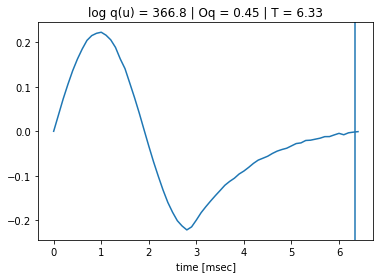

{'T0': DeviceArray(6.32715107, dtype=float64),
 'Oq': DeviceArray(0.45126944, dtype=float64),
 'am': DeviceArray(0.66929335, dtype=float64),
 'Qa': DeviceArray(0.37106856, dtype=float64),
 'Te': DeviceArray(2.8552499, dtype=float64),
 'Tp': DeviceArray(1.91099978, dtype=float64),
 'Ta': DeviceArray(1.28831338, dtype=float64)}

In [5]:
def plot_dgf(i):
    s = lf_samples[i]

    p, t, u, log_prob_u = s['p'], s['t'], s['u'], s['log_prob_u']

    plot(t, u)
    xlabel('time [msec]')
    title(f'log q(u) = {log_prob_u:.1f} | Oq = {p["Oq"]:.2f} | T = {p["T0"]:.2f}');
    axvline(p['T0']);
    show()
    display(s['p'])

plot_dgf(randint(len(lf_samples)))

Check log probability of the samples. It is quite nicely distributed -- see cell 8 in lf.ipynb.

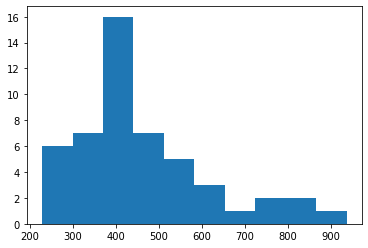

In [6]:
hist([float(s['log_prob_u']) for s in lf_samples], bins=10);

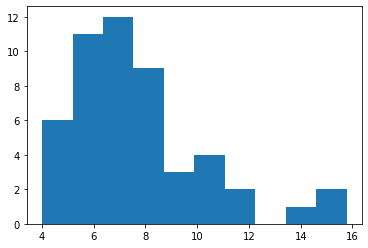

In [14]:
hist([float(s['p']['T0']) for s in lf_samples], bins=10);

## Driver

The code below is the original driver that triggered the calculation of modeling the LF samples. This is now in `source.yield_modeled_lf_samples()`.

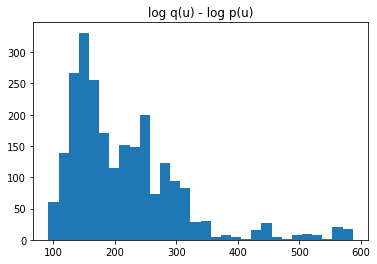

In [136]:
full = dt.fread('dgf/prior/source.csv')

full[:, update(log_prob_diff = f.log_prob_q - f.log_prob_p)]

title('log q(u) - log p(u)')
hist(full['log_prob_diff'], bins=30);

In [71]:
KL = full[:, {
    'KL_ban': log10(e)*dt.mean(f.log_prob_diff)
    },
     dt.by('kernel_name', 'kernel_M', 'use_oq', 'impose_null_integral')
]
KL

,kernel_name,kernel_M,use_oq,impose_null_integral,KL_ban
,▪▪▪▪,▪▪▪▪,▪,▪,▪▪▪▪▪▪▪▪
0,Matern12Kernel,16,0,0,107.948
1,Matern12Kernel,16,0,1,106.806
2,Matern12Kernel,16,1,0,101.927
3,Matern12Kernel,16,1,1,100.803
4,Matern12Kernel,32,0,0,99.6833
5,Matern12Kernel,32,0,1,97.667
6,Matern12Kernel,32,1,0,92.406
7,Matern12Kernel,32,1,1,90.3975
8,Matern12Kernel,64,0,0,95.9185


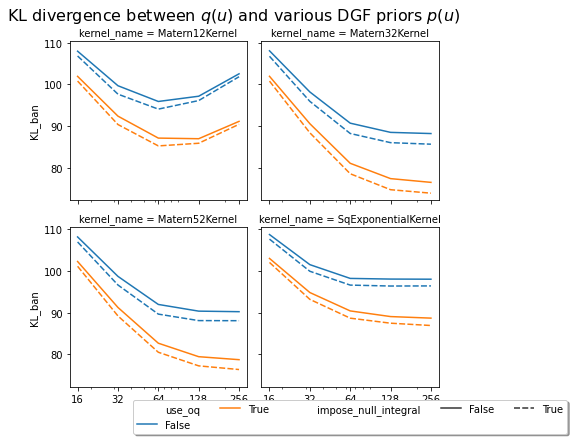

In [ ]:
g = sns.FacetGrid(KL.to_pandas(), col='kernel_name', col_wrap=2, margin_titles=True, despine=False)
g.map_dataframe(sns.lineplot, x="kernel_M", y="KL_ban", hue='use_oq', style='impose_null_integral', legend='brief')
g.set(xscale='log')
g.set(xticks=source.KERNEL_M)
g.set_xticklabels(source.KERNEL_M)
g.fig.suptitle('KL divergence between $q(u)$ and various DGF priors $p(u)$', size=16)
g.fig.subplots_adjust(top=.9)
legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5);

## Show posterior samples of $u$

In [138]:
import dynesty.utils

def get_theta_mean(results):
    samples = results.samples
    weights = np.exp(results.logwt - results.logz[-1])

    # Compute weighted mean and covariance.
    mean, cov = dynesty.utils.mean_and_cov(samples, weights)

    return mean

@jax.jit
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def covariance_matrix(R, noise_power):
    return noise_power*jnp.linalg.inv(R.T @ R + (1/noise_power)*jnp.eye(R.shape[1]))

def mvn_sample_and_log_prob(key, mean, covar):
    b = jax.random.multivariate_normal(key, mean, covar)
    log_prob_b = jax.scipy.stats.multivariate_normal(b, mean, covar)
    return b, log_prob_b

def sample_b(x, key):
    var, r, T, Oq, noise_power = x
    R = kernelmatrix_root_gfd_oq(kernel, var, r, t, M, T, Oq, c)
    b_mean = lstsq(R, u, noise_power)
    b_covar = covariance_matrix(R, noise_power)
    b, log_prob_b = mvn_sample_and_log_prob(key, mean, covar)
    return b, log_prob_b

In [145]:
import dynesty.plotting

def display_results(results):
    display(results.summary())
    display('Information (bans)', results.information[-1] * log10(e))

    VARIABLE_NAMES = source.MODEL_LF_SAMPLE_PARAMS
    fig, axes = dynesty.plotting.traceplot(
        results, show_titles=True,
        labels=VARIABLE_NAMES,
        #truths=[None, None, p['T0'], None, None],
        verbose=True
    )
    tight_layout()

    fg, ax = dynesty.plotting.cornerplot(results, labels=VARIABLE_NAMES)
    tight_layout()
    show()
    return results

def get(i, **kwargs):
    sample = lf_samples[i]
    t = sample['t']
    u = sample['u']
    
    config = dict(
        t = t,
        u = u,
        kernel_name = 'Matern32Kernel',
        kernel_M = 256,
        use_oq = True,
        impose_null_integral = True
    )
    
    config.update(kwargs)
    results = source.model_lf_sample(**config)
    return sample, config, results

def get_and_display_results(i, **kwargs):
    plot_dgf(i)
    sample, config, results = get(i, **kwargs)
    return display_results(results)

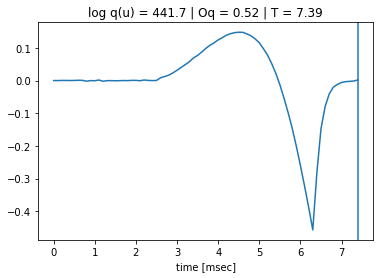

{'T0': array(7.39486685),
 'Oq': array(0.51648194),
 'am': array(0.77554952),
 'Qa': array(0.04399364),
 'Te': array(3.81931514),
 'Tp': array(2.96206802),
 'Ta': array(0.15730153)}

[Memory]1809.4s, 30.2min: Loading model_lf_sample...
Summary
nlive: 100
niter: 2000
ncall: 78181
eff(%):  2.686
logz: 237.707 +/-  0.412


None

'Information (bans)'

5.779759510530198

Quantiles:
noise_power [(0.025, 1.0076812734033764e-06), (0.5, 1.2652724229579082e-06), (0.975, 2.0014764204908334e-06)]
Quantiles:
var [(0.025, 0.06297431740783727), (0.5, 0.38697058526463174), (0.975, 3.2620840403751923)]
Quantiles:
r [(0.025, 0.1624597166781673), (0.5, 0.3061333281825091), (0.975, 0.6273806398375639)]
Quantiles:
T [(0.025, 7.041585517269433), (0.5, 7.171792293972944), (0.975, 7.341566331946982)]
Quantiles:
Oq [(0.025, 0.6355238363571133), (0.5, 0.6446061975803214), (0.975, 0.6577692165551525)]


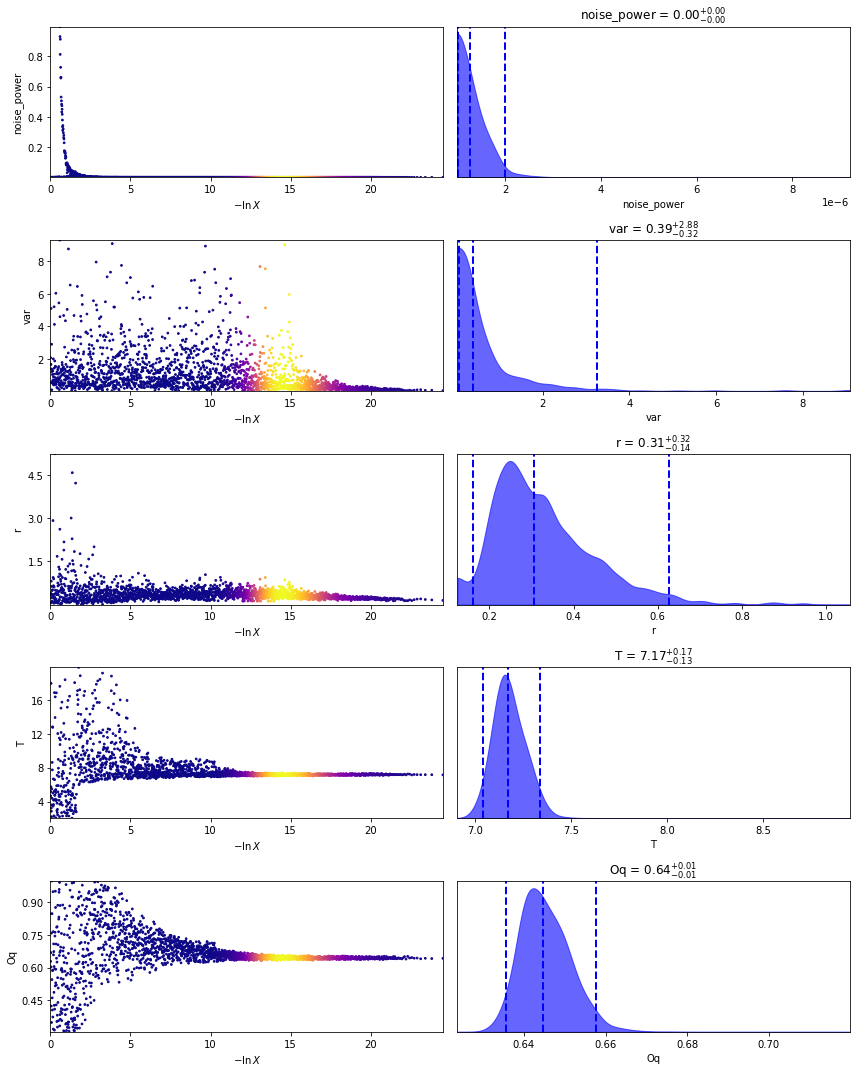

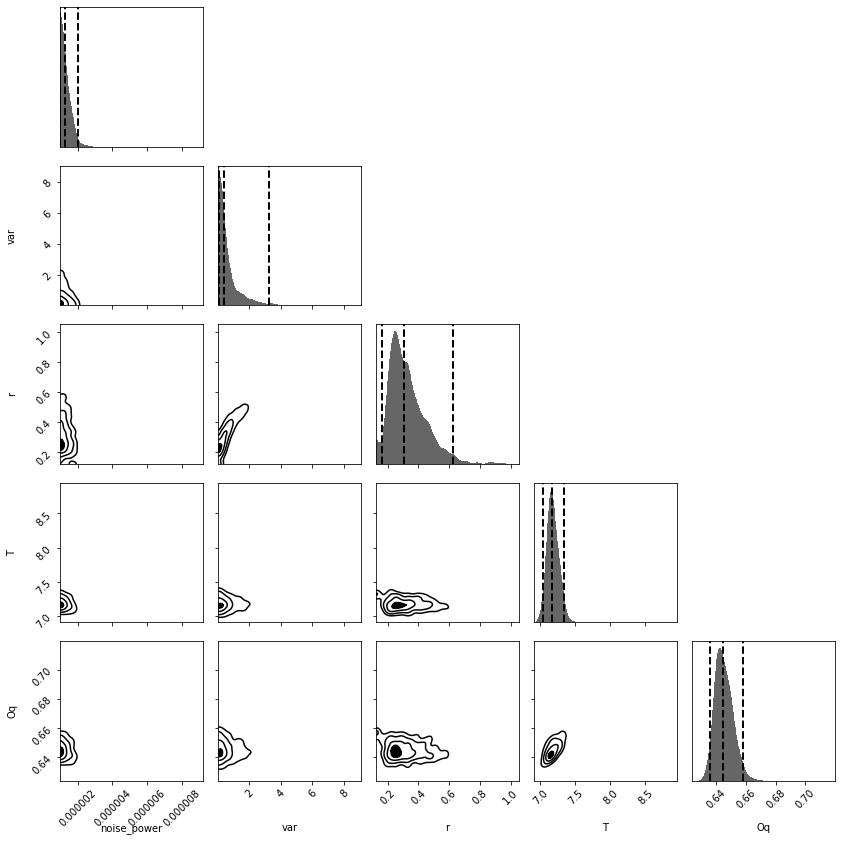

In [146]:
get_and_display_results(0, kernel_M=128);

[Memory]1828.6s, 30.5min: Loading model_lf_sample...


231.3212117913895

14.10803873524793

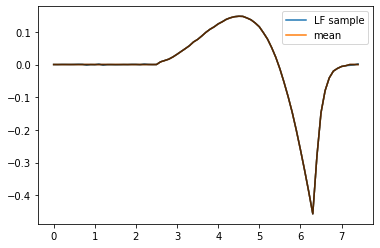

In [147]:
sample, config, results = get(0, kernel_M=128, use_oq=True, impose_null_integral=False)

display(results.logz[-1])
display(results.information[-1])

kernel = isokernels.resolve(config['kernel_name'])
M = config['kernel_M']
t, u = config['t'], config['u']
c = constants.BOUNDARY_FACTOR

noise_power, var, r, T, Oq = results.samples[-1] # Maximum likelihood

R = core.kernelmatrix_root_gfd_oq(kernel, var, r, t, M, T, Oq, c)
w_mean = lstsq(R, u, noise_power)
w_covar = covariance_matrix(R, noise_power)

plot(t, u, label='LF sample')
plot(t, R @ w_mean, label='mean')
#xlim(0, sample['p']['T0'])
k = 10
for i in range(k):
    x = random.multivariate_normal(w_mean, w_covar)
    plot(t, R @ x, color='black', alpha=1/k)
legend();

In [151]:
kernel = isokernels.resolve(config['kernel_name'])
M = config['kernel_M']
t, u = config['t'], config['u']
c = constants.BOUNDARY_FACTOR

NUMFRAMES = 100
stride = int(floor(len(results.samples) / NUMFRAMES))
for frame in range(NUMFRAMES):
    figure()
    iteration = frame*stride
    
    noise_power, var, r, T, Oq = results.samples[iteration]

    R = core.kernelmatrix_root_gfd_oq(kernel, var, r, t, M, T, Oq, c)
    w_mean = lstsq(R, u, noise_power)
    w_covar = covariance_matrix(R, noise_power)

    title(f'iteration {iteration}')
    dt = t[1] - t[0]
    
    plot(t, u, label='LF sample')
    plot(t, R @ w_mean, label='mean')
    xlim(0, sample['p']['T0']*1.1)
    
    k = 10
    for i in range(k):
        x = random.multivariate_normal(w_mean, w_covar)
        plot(t, R @ x, color='black', alpha=1/k)
    legend()
    filename = f'dgf/prior/frame/{frame}.png'
    plt.savefig(filename)
    plt.clf()
    print(filename)

dgf/prior/frame/0.png
dgf/prior/frame/1.png
dgf/prior/frame/2.png
dgf/prior/frame/3.png
dgf/prior/frame/4.png
dgf/prior/frame/5.png
dgf/prior/frame/6.png
dgf/prior/frame/7.png
dgf/prior/frame/8.png
dgf/prior/frame/9.png
dgf/prior/frame/10.png
dgf/prior/frame/11.png
dgf/prior/frame/12.png
dgf/prior/frame/13.png
dgf/prior/frame/14.png
dgf/prior/frame/15.png
dgf/prior/frame/16.png
dgf/prior/frame/17.png
dgf/prior/frame/18.png
dgf/prior/frame/19.png


/tmp/ipykernel_14926/621743874.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


dgf/prior/frame/20.png
dgf/prior/frame/21.png
dgf/prior/frame/22.png
dgf/prior/frame/23.png
dgf/prior/frame/24.png
dgf/prior/frame/25.png
dgf/prior/frame/26.png
dgf/prior/frame/27.png
dgf/prior/frame/28.png
dgf/prior/frame/29.png
dgf/prior/frame/30.png
dgf/prior/frame/31.png
dgf/prior/frame/32.png
dgf/prior/frame/33.png
dgf/prior/frame/34.png
dgf/prior/frame/35.png
dgf/prior/frame/36.png
dgf/prior/frame/37.png
dgf/prior/frame/38.png
dgf/prior/frame/39.png
dgf/prior/frame/40.png
dgf/prior/frame/41.png
dgf/prior/frame/42.png
dgf/prior/frame/43.png
dgf/prior/frame/44.png
dgf/prior/frame/45.png
dgf/prior/frame/46.png
dgf/prior/frame/47.png
dgf/prior/frame/48.png
dgf/prior/frame/49.png
dgf/prior/frame/50.png
dgf/prior/frame/51.png
dgf/prior/frame/52.png
dgf/prior/frame/53.png
dgf/prior/frame/54.png
dgf/prior/frame/55.png
dgf/prior/frame/56.png
dgf/prior/frame/57.png
dgf/prior/frame/58.png
dgf/prior/frame/59.png
dgf/prior/frame/60.png
dgf/prior/frame/61.png
dgf/prior/frame/62.png
dgf/prior/f

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>